# 1D lattice random walk with disorder

_(tv) 2024-06-16_

Consider a one-dimensional nearest-neighbor-hopping random walk, where the transition rates are random.

In [291]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rng = np.random.default_rng()

Master equation for a process with discrete positions:
$$ \partial_t p_n(t)=\sum_{n'}\left(W_{nn'}p_{n'}(t)-W_{n'n}p_n(t)\right) $$
We can write this as
$$ \partial_t p_n(t)=\sum_{n'}\tilde W_{nn'}p_{n'}(t) $$
with $\tilde W_{nn'}=W_{nn'}-\sum_{m}W_{mn}$. Then there holds, for a process with discrete time steps
$$ p_n(t+1)=\sum_{n'}T_{nn'}p_{n'}(t) $$
with $\boldsymbol T=\exp[\tilde{\boldsymbol W}]$.
There needs to hold $T_{nn'}\ge0$ and $\sum_mT_{mn}=1$.

In [175]:
N=100

## Without disorder

For demonstration, we create the probability matrix for the ordinary unbiased random walk with nearest-neighbor transitions. To implement periodic boundary conditions, we start with a matrix of size $N+2$, adding a boundary layer to either side.

In [198]:
W0 = np.diag(np.ones(N+1),k=-1) + np.diag(np.ones(N+1),k=1) + np.diag(-2*np.ones(N+2),k=0)

Periodic boundary conditions then imply: transitions to $N$ should become transitions to $0$, and transitions to $-1$ should become those to $N-1$. Note that indices in `W0` are shifted by one.

In [199]:
W0[:,1]+=W0[:,N+1]

In [200]:
W0[:,N]+=W0[:,0]

This then is the matrix $\tilde{\boldsymbol W}$:

In [202]:
Wtilde=W0[1:N+1,1:N+1]

In [290]:
Wtilde

array([[-2.,  1.,  0., ...,  0.,  0.,  1.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1., -2.]])

To check, it should have the expected equilibrium distribution, $\vec p=(1,1,\ldots)^T$, as a null eigenvector:

In [209]:
(np.dot(Wtilde,np.ones(N))==np.zeros(N)).all()

True

If we start with a state where just one lattice site is occupied, in the long run, we recover the expected Gaussian, with $\sigma^2=2/\delta t$.

In [458]:
T = 10000
dt = 0.01
state = np.zeros(N)
state[N//2]=N
msd = np.zeros(T+1)
for t in range(T):
    state = state + dt*np.dot(Wtilde,state)
    msd[t+1] = np.dot((np.arange(N)-N//2)**2,state)

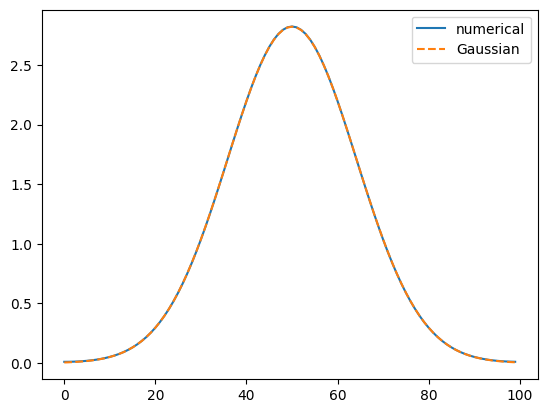

In [459]:
plt.plot(state,label='numerical')
plt.plot(np.arange(N),N*np.exp(-(np.arange(N)-N//2)**2/(2.*200))/np.sqrt(2*np.pi*200),linestyle='dashed',label='Gaussian')
plt.legend()
plt.show()

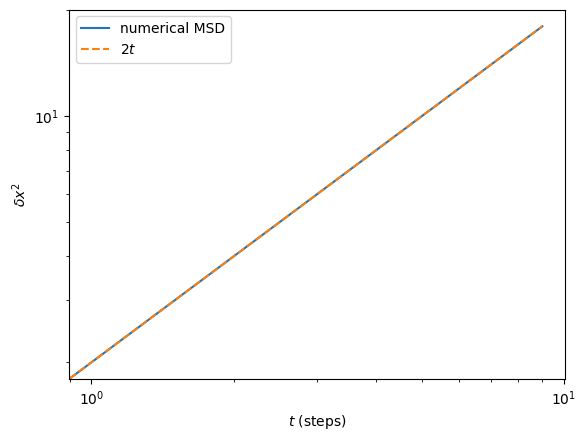

In [521]:
plt.plot(range(10),msd[:10],label='numerical MSD')
plt.plot(range(10),2*np.arange(10),linestyle='dashed',label=r'$2t$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ (steps)')
plt.ylabel(r'$\delta x^2$')
plt.legend()
plt.show()

Let us add a force $F$, implemented by modifying the transition rates according to $W_{i\pm1,i}\mapsto W_{i\pm1,i}\exp[\pm F/2]$. This doesn't really work with periodic boundary conditions, so we restrict to small enough times and implement this on the open line segment.

In [498]:
F = 1
expF=np.diag(np.exp(F/2)*np.ones(N+1),k=1)+np.diag(np.exp(-F/2)*np.ones(N+1),k=-1)

In [499]:
W0F = (np.diag(np.ones(N+1),k=-1) + np.diag(np.ones(N+1),k=1))*expF
W0F = W0F - np.diag(np.sum(W0F,axis=0),k=0)

In [512]:
T = 2000
dt = 0.01
F = 1
stateF = np.zeros(N+2)
stateF[N//2]=N+2
msdF = np.zeros(T+1)
for t in range(T):
    stateF = stateF + dt*np.dot(W0F,stateF)
    msdF[t+1] = np.dot((np.arange(N+2)-N//2)**2,stateF)

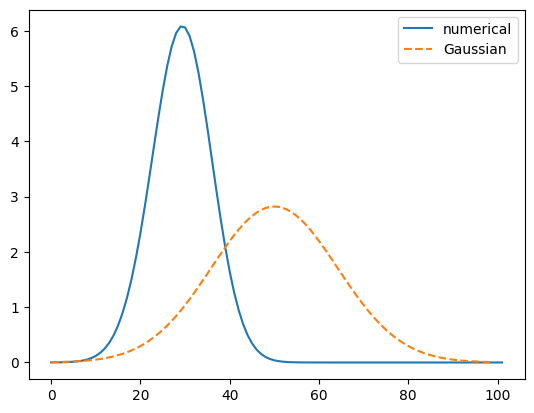

In [513]:
plt.plot(stateF,label='numerical')
plt.plot(np.arange(N),N*np.exp(-(np.arange(N)-N//2)**2/(2.*200))/np.sqrt(2*np.pi*200),linestyle='dashed',label='Gaussian')
plt.legend()
plt.show()

The mean-squared displacement $$\delta x^2=\sum_{ij}(x_i-x_j)^2p(i,t|j,0)$$ crosses over to a $t^2$ asymptote.

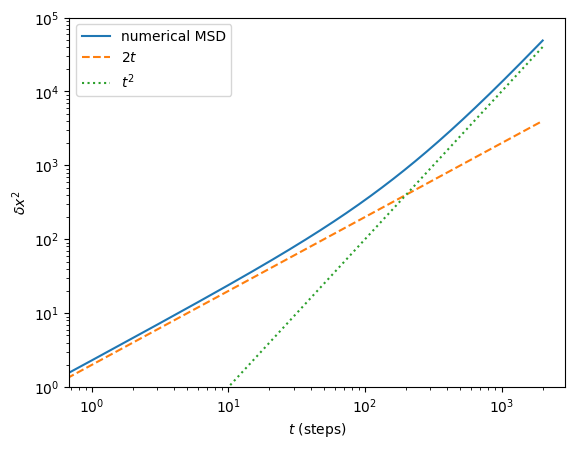

In [520]:
plt.plot(range(T+1),msdF,label='numerical MSD')
plt.plot(range(T),2*np.arange(T),linestyle='dashed',label=r'$2t$')
plt.plot(range(T),F**2*dt*np.arange(T)**2,linestyle='dotted',label=r'$t^2$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ (steps)')
plt.ylabel(r'$\delta x^2$')
plt.ylim(1,1e5)
plt.legend()
plt.show()

## Transition-rate disorder

We now consider the case where all $W_{i\pm1,i}$ are random, but there holds symmetry, $W_{ij}=W_{ji}$. This can be called transition-rate disorder, because it is each transition between two neighboring nodes that is assigned a random probability.

In [293]:
r = rng.lognormal(size=N+1)
W0r = np.diag(r,k=-1) + np.diag(r,k=1)
W0r = W0r - np.diag(np.sum(W0r,axis=0),k=0)

In [294]:
W0r[:,1]+=W0r[:,N+1]
W0r[:,N]+=W0r[:,0]

This then is the matrix $\tilde{\boldsymbol W}$:

In [295]:
Wtilder=W0r[1:N+1,1:N+1]

Maybe remarkably, maybe unsurprisingly, the stationary solution is still the flat equilibrium distribution.

In [296]:
(np.dot(Wtilder,np.ones(N))==np.zeros(N)).all()

True

So in fact, we still have approach to equilibrium in the same manner. The intermediate distributions of course "feel" the randomness in the transition rates. But in the end, the balance is that slow transitions into a site are also balances by slow transitions out of it, and hence each site in stationary state is occupied with equal probability.

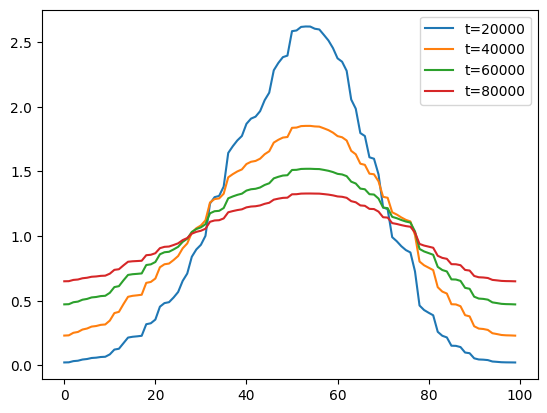

In [297]:
T = 100000
dt = 0.01
state = np.zeros(N)
state[N//2]=N
for t in range(T):
    state = state + dt*np.dot(Wtilder,state)
    if t>0 and not t%(T//5): plt.plot(state,label='t={}'.format(t))
plt.legend()
plt.show()

Just as a check, we are not "losing" any particles, we only introduce mild errors due to numerical rounding:

In [299]:
np.sum(state)/N

0.9919247214142523

## Potential-barrier disorder

Now consider the case where $W_{i\pm1,i}=W_0\exp[-\beta\varepsilon_i]$ with random energy levels $\varepsilon_i$. This case can be considered as disorder in the potential barriers (or the energy levels assigned to each lattice site), since the transitions are no longer symmetric: hopping out of a deep well into a neighboring shallow well is much harder than the reverse transition.

In [406]:
r = rng.lognormal(size=N+2)
W0pb = np.diag(r[:N+1],k=-1) + np.diag(r[1:],k=1)
W0pb = W0pb - np.diag(np.sum(W0pb,axis=0),k=0)

This matrix fulfills $W_{i+1,i}/W_{i-1,i}=W_0$, and that still makes it a detailled-balance process, since we have $W_{j,i}p_i=W_{i,j}p_j$ if we set $$p_i=(1/Z)\exp[-\beta\varepsilon_i]$$

In [407]:
W0pb[range(2,N+2),range(1,N+1)] / W0pb[range(0,N),range(1,N+1)]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The transitions are nowno longer symmetric:

In [408]:
((W0pb-W0pb.T)==np.zeros((N+2,N+2))).all()

False

But detailed balance, $$W_{j,i}p_i=W_{i,j}p_j$$ holds with the equilibrium distribution, which in fact is just given by our random vector `r`:

In [414]:
np.isclose(np.dot(W0pb,1/r),np.zeros(N+2)).all() # 1/r is equilibrium distribution

True

In [415]:
((W0pb/r)-(W0pb/r).T==np.zeros((N+2,N+2))).all() # detailed balance holds

True

Fix periodic boundary conditions:

In [397]:
W0pb[1,1],np.sum(W0pb[2:,1])+np.sum(W0pb[:1,1])

(-3.9443255672740083, 3.9443255672740083)

In [398]:
W0pb[:,1]+=W0pb[:,N+1]
W0pb[:,N]+=W0pb[:,0]

In [399]:
W0pb[1,1],np.sum(W0pb[2:,1])+np.sum(W0pb[:1,1])

(-3.9443255672740083, 3.9443255672740083)

In [400]:
np.sum(W0pb,axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Note that in this case our implementation of periodic boundary conditions messes things up, we thus keep open boundaries for now. We then see the approach over time to a distribution that is far from flat, but instead modulated with the potential-energy barriers that we chose randomly.

In [431]:
#Wtildepb=W0pb[1:N+1,1:N+1]
Wtildepb=W0pb

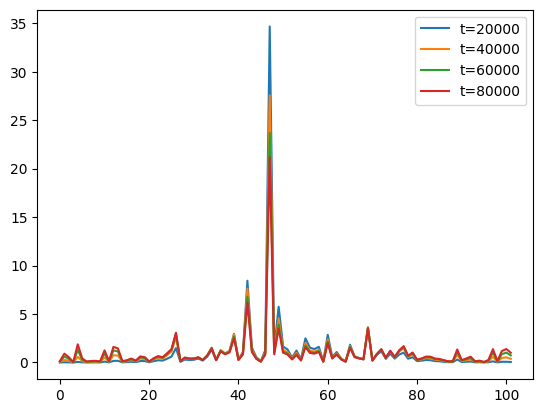

In [442]:
T = 100000
dt = 0.01
#state = np.ones(Wtildepb.shape[0])
state = np.zeros(Wtildepb.shape[0])
state[N//2]=Wtildepb.shape[0]
for t in range(T):
    state = state + dt*np.dot(Wtildepb,state)
    if t>0 and not t%(T//5): plt.plot(state,label='t={}'.format(t))
plt.legend()
plt.show()

In [522]:
np.sum(state)/len(state)

0.9999999999999984

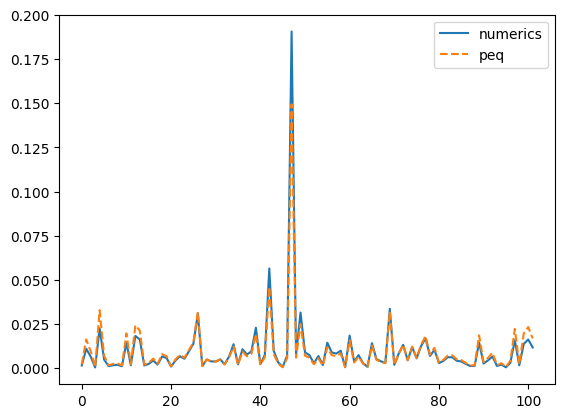

In [444]:
plt.plot(np.arange(N+2),state/np.sum(state),label='numerics')
plt.plot(np.arange(N+2),1/r/np.sum(1/r),linestyle='dashed',label='peq')
plt.legend()
plt.show()

Recall the discussion of the Brownian-motion stochastic differential equation with spatial-dependent diffusion coefficient? There it depends on the calculus (Itô, Stratonovich or something different) whether the stationary distribution depends on the diffusion coefficient or not. This here is sort of the conjugate example for a lattice process: it depends on whether we implement randomness in the rates or in the site energies.